In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.datasets import make_regression
import tensorflow as tf
from keras import backend as K
import itertools
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Layer, InputLayer
from keras.utils import plot_model, to_categorical
from custum_func import my_acc, my_loss, ExponentialLayer, ControlledDropoutLayer, dropout_conf_1, dropout_conf_2, dropout_conf_3, PowLayer, dropout_conf_4
import pickle
from keras.utils import CustomObjectScope

2023-05-31 16:13:00.887755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 16:13:01.101325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-31 16:13:01.101352: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-31 16:13:02.526691: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Data

In [3]:
# load train_data

train_data = pd.read_csv(
    "../data_acquisition/data_0.3/training_standardized.csv", sep=";"
)

features = np.swapaxes(
    np.array(
        [
            train_data["home_xG"],
            train_data["home_xg_against"],
            train_data["away_xG"],
            train_data["away_xg_against"],
            train_data["home_xT_all"],
            train_data["home_xt_all_against"],
            train_data["away_xT_all"],
            train_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (train_data["ha_form_home_for"]),
            (train_data["ha_form_home_against"]),
            (train_data["ha_form_away_for"]),
            (train_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(
    np.array([train_data["home_score"], train_data["away_score"]]), 0, 1
)

elo_diff = np.swapaxes(
    np.array([(train_data["elo_diff_home"]), (train_data["elo_diff_away"])]), 0, 1
)

X = np.concatenate([features, form, elo_diff], axis=1)
y = np.array(goals, dtype=float)

In [4]:
test_data = pd.read_csv(
    "../data_acquisition/data_0.3/test_standardized.csv", sep=";"
).dropna()


features = np.swapaxes(
    np.array(
        [
            test_data["home_xG"],
            test_data["home_xg_against"],
            test_data["away_xG"],
            test_data["away_xg_against"],
            test_data["home_xT_all"],
            test_data["home_xt_all_against"],
            test_data["away_xT_all"],
            test_data["away_xt_all_against"],
        ]
    ),
    0,
    1,
)

form = np.swapaxes(
    np.array(
        [
            (test_data["ha_form_home_for"]),
            (test_data["ha_form_home_against"]),
            (test_data["ha_form_away_for"]),
            (test_data["ha_form_away_against"]),
        ]
    ),
    0,
    1,
)

goals = np.swapaxes(np.array([test_data["home_score"], test_data["away_score"]]), 0, 1)

elo = np.swapaxes(
    np.array([(test_data["elo_diff_home"]), (test_data["elo_diff_away"])]), 0, 1
)
X_test = np.concatenate([features, form, elo], axis=1)
y_test = np.array(goals, dtype=float)

In [5]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train or Load Model

In [6]:
# select train or load
TRAIN_MODEL = False

In [7]:
if TRAIN_MODEL:
    dconf1, dconf2 = dropout_conf_3(64)
    step_size = len(dconf1)
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 1)))
    model.add(ControlledDropoutLayer(dconf1))
    model.add(LSTM(64))
    model.add(ControlledDropoutLayer(dconf2))
    model.add(Dense(2, activation="linear"))

    model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
    model.summary()
    hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

    # save trained model 
    if False:
        with open("models/lstm_dropout_3.pck", 'wb') as outp:
            pickle.dump(model, outp, pickle.HIGHEST_PROTOCOL)
else:
    with CustomObjectScope({'ControlledDropoutLayer': ControlledDropoutLayer}):
        with open('models/lstm_dropout_3.pck', 'rb') as f:
            model = pickle.load(f)
            step_size = len(dropout_conf_3(64)[0])

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-05-10 21:22:04       270360
config.json                                    2023-05-10 21:22:04       113222
metadata.json                                  2023-05-10 21:22:04           64


2023-05-31 16:13:05.295399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-31 16:13:05.295470: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-31 16:13:05.295516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (morten-thinkpad): /proc/driver/nvidia/version does not exist
2023-05-31 16:13:05.296016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......controlled_dropout_layer
.........vars
......controlled_dropout_layer_1
.........vars
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


# Create predictions

In [8]:
preds = []
for x in range(step_size):
    preds.append(model(X_test))
preds = np.stack(preds)
predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

# Std

In [9]:
home_std = np.std(predictions_home, axis=1)
away_std = np.std(predictions_away, axis=1)
print(f"Home std: {home_std.mean()}, Away std: {away_std.mean()}, Overall std: {(home_std.mean() + away_std.mean()) / 2}")
# Draw std Boxplots
if False:
    fig, (ax1, ax2) = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    ax1[0].scatter(home_std, np.arange(1545))
    ax2[0].scatter(away_std, np.arange(1545))
    ax1[1].boxplot(home_std)
    ax2[1].boxplot(away_std)

Home std: 3.7278645038604736, Away std: 3.6454246044158936, Overall std: 3.6866445541381836


In [10]:
act_res = []
for h, a in y_test:
    act_res.append(f"{str(int(h))}:{str(int(a))}")

predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

game_quotes = []
most_goals = {"home": [], "away": []}
for game_idx in range(len(predictions_home)):
    game_df = pd.DataFrame(
        {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
    )
    game_df["diff"] = game_df["home"] - game_df["away"]
    game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
    game_df["rounded_res"] = np.rint(game_df["clipped_res"])
    home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
    draw = (
        game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
    )
    away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

df_res = pd.DataFrame(
    {"actual": act_res, "predicted": game_quotes}
)  
df_cross = pd.DataFrame(
    {
        "actual": [
            0
            if int(df_res.iloc[i]["actual"].split(":")[0])
            > int(df_res.iloc[i]["actual"].split(":")[1])
            else 1
            if int(df_res.iloc[i]["actual"].split(":")[0])
            == int(df_res.iloc[i]["actual"].split(":")[1])
            else 2
            for i in range(df_res.shape[0])
        ],
        "pred": [
            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "pred_val": [
            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
            for i in range(df_res.shape[0])
        ],
        "bookie": [
            np.argmax(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
        "bookie_val": [
            np.max(
                [
                    test_data.iloc[i].bookie_home,
                    test_data.iloc[i].bookie_draw,
                    test_data.iloc[i].bookie_away,
                ]
            )
            for i in range(test_data.shape[0])
        ],
    }
)


In [15]:
print("Verteilung:")
print(
    f"Anzahl Predicted Home: {df_cross[df_cross['pred'] == 0].shape[0]} ({round(df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Home: {round(df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Draw: {df_cross[df_cross['pred'] == 1].shape[0]} ({round(df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Draw: {round(df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    f"Anzahl Predicted Away: {df_cross[df_cross['pred'] == 2].shape[0]} ({round(df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%)",
    end="",
)
print(
    f" | Verteilung Tatsächlich Away: {round(df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0] * 100, 2)}%"
)
print(
    "---------------------------------------------------------------------------------"
)
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_cross.shape[0]):
    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
        if df_cross.iloc[x]["pred"] == 0:
            if df_cross.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_cross.iloc[x]["pred"] == 1:
            if df_cross.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_cross.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_cross.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_cross.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_cross.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_cross[df_cross['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(f"Home Pred. aber Draw --> {home_pred['act_draw']}")
print(f"Home Pred. aber Away --> {home_pred['act_away']}")
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_cross[df_cross['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(f"Draw Pred. aber Home --> {draw_pred['act_home']}")
print(f"Draw Pred. aber Away --> {draw_pred['act_away']}")
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_cross[df_cross['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(f"Away Pred. aber Home --> {away_pred['act_home']}")
print(f"Away Pred. aber Draw --> {away_pred['act_draw']}")

print(
    "---------------------------------------------------------------------------------"
)
print(f"Precision: ")
print(f"Home --> {home_right / (df_cross[df_cross['pred'] == 0].shape[0])}")
print(f"Draw --> {draw_right / (df_cross[df_cross['pred'] == 1].shape[0])}")
print(f"Away --> {away_right / (df_cross[df_cross['pred'] == 2].shape[0])}")
print(f"All mac --> {((home_right / (df_cross[df_cross['pred'] == 0].shape[0])) + (draw_right / (df_cross[df_cross['pred'] == 1].shape[0])) + (away_right / (df_cross[df_cross['pred'] == 2].shape[0]))) / 3}")
print(f"All mic --> {((home_right / (df_cross[df_cross['pred'] == 0].shape[0])) * (df_cross[df_cross['pred'] == 0].shape[0] / df_cross.shape[0]) + (draw_right / (df_cross[df_cross['pred'] == 1].shape[0]))  * (df_cross[df_cross['pred'] == 1].shape[0] / df_cross.shape[0]) + (away_right / (df_cross[df_cross['pred'] == 2].shape[0])) * (df_cross[df_cross['pred'] == 2].shape[0] / df_cross.shape[0]))}")

print(
    "---------------------------------------------------------------------------------"
)
print(f"Recall: ")
print(f"Home --> {home_right / (df_cross[df_cross['actual'] == 0].shape[0])}")
print(f"Draw --> {draw_right / (df_cross[df_cross['actual'] == 1].shape[0])}")
print(f"Away --> {away_right / (df_cross[df_cross['actual'] == 2].shape[0])}")
print(f"All mac --> {((home_right / (df_cross[df_cross['actual'] == 0].shape[0])) + (draw_right / (df_cross[df_cross['actual'] == 1].shape[0])) + (away_right / (df_cross[df_cross['actual'] == 2].shape[0]))) / 3}")
print(f"All mic --> {((home_right / (df_cross[df_cross['actual'] == 0].shape[0])) * (df_cross[df_cross['actual'] == 0].shape[0] / df_cross.shape[0]) + (draw_right / (df_cross[df_cross['actual'] == 1].shape[0]))  * (df_cross[df_cross['actual'] == 1].shape[0] / df_cross.shape[0]) + (away_right / (df_cross[df_cross['actual'] == 2].shape[0])) * (df_cross[df_cross['actual'] == 2].shape[0] / df_cross.shape[0]))}")

Verteilung:
Anzahl Predicted Home: 602 (38.96%) | Verteilung Tatsächlich Home: 42.78%
Anzahl Predicted Draw: 572 (37.02%) | Verteilung Tatsächlich Draw: 25.5%
Anzahl Predicted Away: 371 (24.01%) | Verteilung Tatsächlich Away: 31.72%
---------------------------------------------------------------------------------
Prediction:
Anzahl Korrekt: 843 (54.56%), Anzahl Falsch: 702 (45.44%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 406 (67.44%), Anzahl Home Falsch: 196
Home Pred. aber Draw --> 120
Home Pred. aber Away --> 76
Anzahl Draw Korrekt: 192 (33.57%), Anzahl Draw Falsch: 380
Draw Pred. aber Home --> 211
Draw Pred. aber Away --> 169
Anzahl Away Korrekt: 245 (66.04%), Anzahl Away Falsch: 126
Away Pred. aber Home --> 44
Away Pred. aber Draw --> 82
---------------------------------------------------------------------------------
Precision: 
Home --> 0.6744186046511628
Draw --> 0.3356643356643357
Away --> 0.660377358490566
All mac 

In [16]:
pred_difficulty = test_data[["home_score", "away_score", "bookie_home", "bookie_draw", "bookie_away"]].copy()
conditions = [((pred_difficulty["bookie_home"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] > pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_draw"] >= pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] == pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_away"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_home"]) & (pred_difficulty["home_score"] < pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_home"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] <= pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_draw"] >= pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"]) & (pred_difficulty["home_score"] != pred_difficulty["away_score"])),
              ((pred_difficulty["bookie_away"] >= pred_difficulty["bookie_draw"] + pred_difficulty["bookie_home"]) & (pred_difficulty["home_score"] >= pred_difficulty["away_score"])),
              (((pred_difficulty["bookie_home"] < pred_difficulty["bookie_draw"] + pred_difficulty["bookie_away"])) & 
               ((pred_difficulty["bookie_draw"] < pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"])) & 
               ((pred_difficulty["bookie_away"] < pred_difficulty["bookie_home"] + pred_difficulty["bookie_away"])))
               ]
values = ["easy", "easy", "easy", "upset", "upset", "upset", "hard"]

pred_difficulty["difficulty"] = np.select(conditions, values)
print(pred_difficulty["difficulty"].value_counts())

df_cross["class"] = pred_difficulty["difficulty"]
df_easy = df_cross[df_cross["class"] == "easy"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_easy.shape[0]):
    if df_easy.iloc[x]["actual"] != df_easy.iloc[x]["pred"]:
        if df_easy.iloc[x]["pred"] == 0:
            if df_easy.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_easy.iloc[x]["pred"] == 1:
            if df_easy.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_easy.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_easy.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_easy.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1

home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Easy:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_easy.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_easy.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_easy[df_easy['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_easy[df_easy['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_easy[df_easy['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(
    "---------------------------------------------------------------------------------\n"
    "---------------------------------------------------------------------------------"
)

df_hard = df_cross[df_cross["class"] == "hard"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_hard.shape[0]):
    if df_hard.iloc[x]["actual"] != df_hard.iloc[x]["pred"]:
        if df_hard.iloc[x]["pred"] == 0:
            if df_hard.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_hard.iloc[x]["pred"] == 1:
            if df_hard.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_hard.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_hard.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_hard.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1
home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Hard:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_hard.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_hard.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_hard[df_hard['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_hard[df_hard['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_hard[df_hard['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)
print(
    "---------------------------------------------------------------------------------\n"
    "---------------------------------------------------------------------------------"
)

df_upset = df_cross[df_cross["class"] == "upset"]
right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
home_pred = {"act_away": 0, "act_draw": 0}
draw_pred = {"act_away": 0, "act_home": 0}
away_pred = {"act_home": 0, "act_draw": 0}
for x in range(df_upset.shape[0]):
    if df_upset.iloc[x]["actual"] != df_upset.iloc[x]["pred"]:
        if df_upset.iloc[x]["pred"] == 0:
            if df_upset.iloc[x]["actual"] == 1:
                home_pred["act_draw"] += 1
            else:
                home_pred["act_away"] += 1
        elif df_upset.iloc[x]["pred"] == 1:
            if df_upset.iloc[x]["actual"] == 0:
                draw_pred["act_home"] += 1
            else:
                draw_pred["act_away"] += 1
        else:
            if df_upset.iloc[x]["actual"] == 0:
                away_pred["act_home"] += 1
            else:
                away_pred["act_draw"] += 1
        wrong += 1
    else:
        if df_upset.iloc[x]["actual"] == 0:
            home_right += 1
        elif df_upset.iloc[x]["actual"] == 1:
            draw_right += 1
        else:
            away_right += 1
        right += 1
home_wrong = home_pred["act_away"] + home_pred["act_draw"]
draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
away_wrong = away_pred["act_home"] + away_pred["act_draw"]
print("Prediction Upset:")
print(
    f"Anzahl Korrekt: {right} ({round(right / df_upset.shape[0] * 100,2)}%), Anzahl Falsch: {wrong} ({round(wrong / df_upset.shape[0] * 100, 2)}%)"
)
print(
    "---------------------------------------------------------------------------------"
)
print(
    f"Anzahl Home Korrekt: {home_right} ({round(home_right / df_upset[df_upset['pred'] == 0].shape[0] * 100, 2)}%), Anzahl Home Falsch: {home_wrong}"
)
print(
    f"Anzahl Draw Korrekt: {draw_right} ({round(draw_right / df_upset[df_upset['pred'] == 1].shape[0] * 100, 2)}%), Anzahl Draw Falsch: {draw_wrong}"
)
print(
    f"Anzahl Away Korrekt: {away_right} ({round(away_right / df_upset[df_upset['pred'] == 2].shape[0] * 100, 2)}%), Anzahl Away Falsch: {away_wrong}"
)

hard     793
easy     475
upset    277
Name: difficulty, dtype: int64
Prediction Easy:
Anzahl Korrekt: 355 (74.74%), Anzahl Falsch: 120 (25.26%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 251 (97.67%), Anzahl Home Falsch: 6
Anzahl Draw Korrekt: 0 (0.0%), Anzahl Draw Falsch: 107
Anzahl Away Korrekt: 104 (93.69%), Anzahl Away Falsch: 7
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Prediction Hard:
Anzahl Korrekt: 392 (49.43%), Anzahl Falsch: 401 (50.57%)
---------------------------------------------------------------------------------
Anzahl Home Korrekt: 142 (58.68%), Anzahl Home Falsch: 100
Anzahl Draw Korrekt: 126 (36.0%), Anzahl Draw Falsch: 224
Anzahl Away Korrekt: 124 (61.69%), Anzahl Away Falsch: 77
---------------------------------------------------------------------------------
--------------------------

# Average predictions

In [12]:
h = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,0]
d = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,1]
a = np.array([np.array(xi, dtype=float) for xi in df_res.predicted.str.split("-")])[:,2]

print(np.mean(h))
print(np.mean(d))
print(np.mean(a))

0.4108097087378641
0.2727624595469256
0.31648932038834954


Observed: Home: 1.5348569549490299, away: 1.2387372574810918
Predicted: Home:1.1706587956902628, Away: 0.8985969782977827


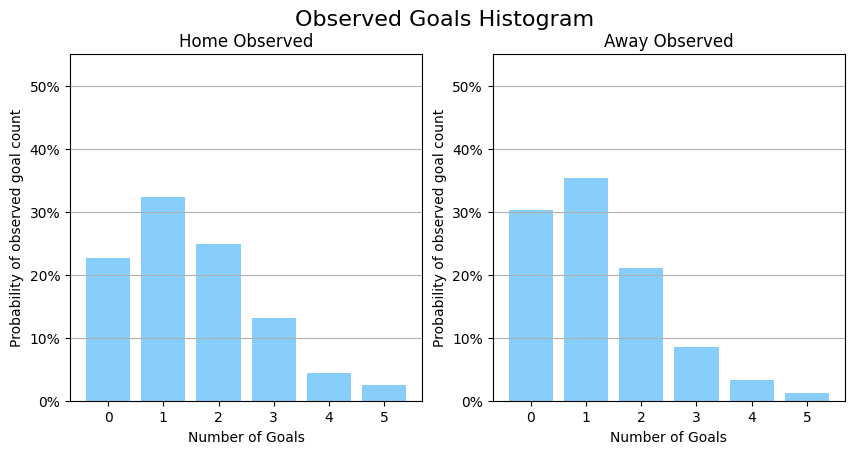

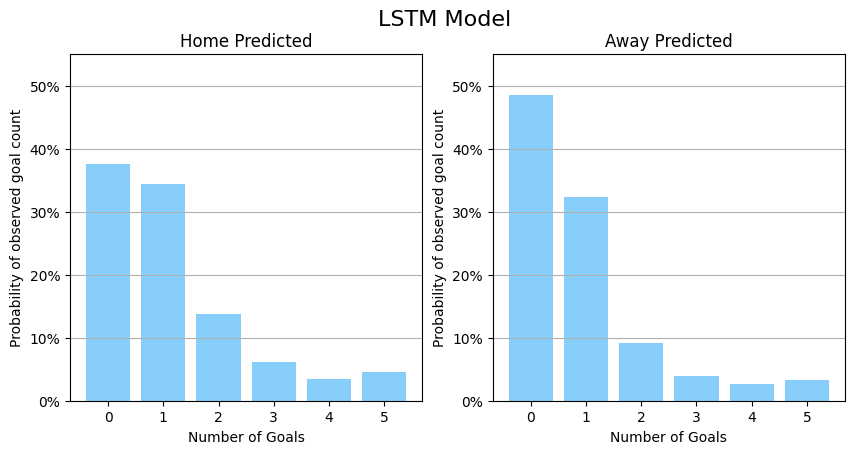

In [23]:
home_histograms, away_histograms = [], []
for game_idx in range(len(predictions_home)):
    home_hist, bin_edges = np.histogram(
        np.array(predictions_home[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    away_hist, bin_edges = np.histogram(
        np.array(predictions_away[game_idx], dtype=int), [0, 1, 2, 3, 4, 5, 6]
    )
    home_histograms.append(home_hist)
    away_histograms.append(away_hist)

home_cum_hist = np.sum(home_histograms, axis=0)
away_cum_hist = np.sum(away_histograms, axis=0)

if True: # draw histograms
    his_h, _ = np.histogram(train_data.home_score, [0, 1, 2, 3, 4, 5, 6])
    his_a, _ = np.histogram(train_data.away_score, [0, 1, 2, 3, 4, 5, 6])
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4.5)
    fig.suptitle("Observed Goals Histogram", fontsize=16)
    ax1.bar(np.arange(len(his_h)), his_h / np.sum(his_h), color="lightskyblue")
    ax1.set_title("Home Observed")
    ax1.set_xlabel("Number of Goals")
    ax1.set_ylabel("Probability of observed goal count")
    ax1.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1.grid(axis="y")
    ax2.bar(np.arange(len(his_a)), his_a / np.sum(his_a), color="lightskyblue")
    ax2.set_title("Away Observed")
    ax2.set_xlabel("Number of Goals")
    ax2.set_ylabel("Probability of observed goal count")
    ax2.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2.grid(axis="y")
    ax2.set_ylim([0,0.55])
    ax1.set_ylim([0,0.55])


    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4.5)
    fig.suptitle("LSTM Model", fontsize=16)
    ax1.bar(
        np.arange(len(home_cum_hist)),
        home_cum_hist / np.sum(home_cum_hist),
        color="lightskyblue",
    )
    ax1.set_title("Home Predicted")
    ax1.set_xlabel("Number of Goals")
    ax1.set_ylabel("Probability of observed goal count")
    ax1.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax1.grid(axis="y")
    ax2.bar(
        np.arange(len(away_cum_hist)),
        away_cum_hist / np.sum(away_cum_hist),
        color="lightskyblue",
    )
    ax2.set_title("Away Predicted")
    ax2.set_xlabel("Number of Goals")
    ax2.set_ylabel("Probability of observed goal count")
    ax2.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x * 100), ",") + "%")
    )
    ax2.grid(axis="y")
    ax2.set_ylim([0,0.55])
    ax1.set_ylim([0,0.55])


print(f"Observed: Home: {np.mean(train_data.home_score)}, away: {np.mean(train_data.away_score)}")
print(f"Predicted: Home:{np.sum([x * idx for idx, x in enumerate(home_cum_hist)]) / np.sum(home_cum_hist)}, Away: {np.sum([x * idx for idx, x in enumerate(away_cum_hist)]) / np.sum(away_cum_hist)}")

Observed: Over: 0.40194174757281564, Diagonal: 0.25501618122977343, Under: 0.30226537216828475, Sum:0.9592233009708738
Predicted: Over: 0.3951231598134413, Diagonal: 0.34036689529648484, Under: 0.26450994489007335, Sum:0.9999999999999996


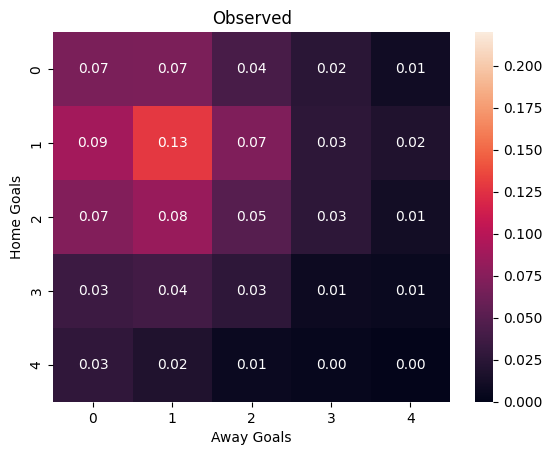

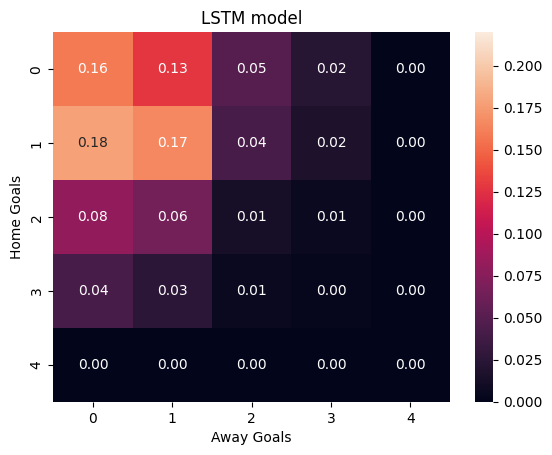

In [33]:
if True:
    # actual
    max_goals = int(np.max(y_test)) + 1
    res_table_a = np.array([np.zeros(max_goals) for _ in range(max_goals)])
    for h, a in y_test:
        res_table_a[int(h)][int(a)] += 1
    res_table_a = res_table_a / test_data.shape[0]

    # predicted
    max_goals = int(np.max(y_test)) + 1
    res_table_p = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4]
        )
        if home_hist.shape[0] < max_goals:
            home_hist = np.append(home_hist, np.zeros(max_goals - home_hist.shape[0]))
        if away_hist.shape[0] < max_goals:
            away_hist = np.append(away_hist, np.zeros(max_goals - away_hist.shape[0]))

        home_hist = home_hist / sum(home_hist) # step_size
        away_hist = away_hist / sum(away_hist) # step_size
        probs = home_hist.reshape(home_hist.shape[0], 1) * away_hist
        probs = probs
        res_table_p += probs

    res_table_p = res_table_p / test_data.shape[0]

    # sb.heatmap(res_table_p, annot=True)

    # top pred result:
    max_goals = int(np.max(y_test)) + 1
    res_table_pr = np.array([np.zeros(max_goals) for _ in range(max_goals)])

    game_quotes = []
    for game_idx in range(len(predictions_home)):
        home_hist, bin_edges = np.histogram(
            predictions_home[game_idx], [0, 1, 2, 3, 4]
        )
        away_hist, bin_edges = np.histogram(
            predictions_away[game_idx], [0, 1, 2, 3, 4]
        )
        res_table_pr[np.argmax(home_hist)][np.argmax(away_hist)] += 1
    res_table_pr = res_table_pr / test_data.shape[0]
    # sb.heatmap(res_table_pr, annot=True)


    res_table_a = res_table_a[:5, :5]
    res_table_p = res_table_p[:5, :5]


    fig, axes = plt.subplots(1, 1)
    # fig.suptitle("Independent Poisson Model")
    sb.heatmap(ax=axes, data=res_table_a, annot=True, fmt=".2f", vmin=0, vmax=0.22)
    axes.set_title("Observed")
    axes.set_ylabel("Home Goals")
    axes.set_xlabel("Away Goals")
    fig, axes = plt.subplots(1, 1)
    # fig.suptitle("Independent Poisson Model")
    sb.heatmap(ax=axes, data=res_table_p, annot=True, fmt=".2f", vmin=0, vmax=0.22)
    axes.set_title("LSTM model")
    axes.set_ylabel("Home Goals")
    axes.set_xlabel("Away Goals")

    print(f"Observed: Over: {np.tril(res_table_a).sum() - np.trace(res_table_a)}, Diagonal: {np.trace(res_table_a)}, Under: {np.triu(res_table_a).sum() - np.trace(res_table_a)}, Sum:{np.tril(res_table_a).sum() - np.trace(res_table_a) + np.trace(res_table_a) + np.triu(res_table_a).sum() - np.trace(res_table_a)}")
    print(f"Predicted: Over: {np.tril(res_table_p).sum() - np.trace(res_table_p)}, Diagonal: {np.trace(res_table_p)}, Under: {np.triu(res_table_p).sum() - np.trace(res_table_p)}, Sum:{np.tril(res_table_p).sum() - np.trace(res_table_p) + np.trace(res_table_p) + np.triu(res_table_p).sum() - np.trace(res_table_p)}")


# ECE

In [15]:
# ece
data_length = df_cross.shape[0]
acc_home = (
    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
) / df_cross.loc[df_cross["actual"] == 0].shape[0]
acc_draw = (
    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
) / df_cross.loc[df_cross["actual"] == 1].shape[0]
acc_away = (
    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
) / df_cross.loc[df_cross["actual"] == 2].shape[0]

conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
print(f"Predicted ECE Home: {abs(acc_home - conf_home)}")
print(f"Predicted ECE Draw: {abs(acc_draw - conf_draw)}")
print(f"Predicted ECE Away: {abs(acc_away - conf_away)}")

Predicted ECE Home: 0.09332563416951056
Predicted ECE Draw: 0.06317462106421501
Predicted ECE Away: 0.1813935309973046


# Betting

In [16]:
bet_threshold = 10
bets, bets_won, bets_lost = 0, 0, 0
risk, money = 10, 0
for idx, x in df_res.iterrows():
    res = x.actual.split(":")
    result = 0 if res[0] > res[1] else 1 if res[0] == res[1] else 2
    pred = x.predicted.split("-")
    pred_h, pred_d, pred_a = pred[0], pred[1], pred[2]
    bookie_h, bookie_d, bookie_a = (
        test_data.iloc[idx].bookie_home,
        test_data.iloc[idx].bookie_draw,
        test_data.iloc[idx].bookie_away,
    )
    bookie_h_odd, bookie_d_odd, bookie_a_odd = (
        test_data.iloc[idx].bookie_home_odd,
        test_data.iloc[idx].bookie_draw_odd,
        test_data.iloc[idx].bookie_away_odd,
    )
    if (float(pred_h) * 100) - bookie_h > bet_threshold:
        bets += 1
        if result == 0:
            bets_won += 1
            money += risk * (bookie_h_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_d) * 100) - bookie_d > bet_threshold:
        bets += 1
        if result == 1:
            bets_won += 1
            money += risk * (bookie_d_odd) - risk
        else:
            bets_lost += 1
            money -= risk
    if (float(pred_a) * 100) - bookie_a > bet_threshold:
        bets += 1
        if result == 2:
            bets_won += 1
            money += risk * (bookie_a_odd) - risk
        else:
            bets_lost += 1
            money -= risk

print(f"bets: {bets}")
print(f"won: {bets_won}")
print(f"lost: {bets_lost}")
print("money: ", money)

# bets: 1004
# won: 467
# lost: 537
# money:  6749.102471962487

bets: 1351
won: 638
lost: 713
money:  5224.399999999999


# Backup training procedure

In [17]:
if False:
    dconf1, dconf2 = dropout_conf_3(64)
    step_size = len(dconf1)
    model = Sequential()
    model.add(InputLayer(input_shape=(14, 1)))
    model.add(ControlledDropoutLayer(dconf1))
    model.add(LSTM(64))
    model.add(ControlledDropoutLayer(dconf2))
    model.add(Dense(2, activation="linear"))
    # model.add(ExponentialLayer(2))

    model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
    hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

    preds = []
    for x in range(step_size):
        preds.append(model(X_test))

    preds = np.stack(preds)
    predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
    predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
    home_std = np.std(predictions_home, axis=1)
    away_std = np.std(predictions_away, axis=1)

    print(((home_std.mean() + away_std.mean()) / 2))

    act_res = []
    for h, a in y_test:
        act_res.append(f"{str(int(h))}:{str(int(a))}")

    predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
    predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

    game_quotes = []
    most_goals = {"home": [], "away": []}
    for game_idx in range(len(predictions_home)):
        game_df = pd.DataFrame(
            {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
        )
        game_df["diff"] = game_df["home"] - game_df["away"]
        game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
        game_df["rounded_res"] = np.rint(game_df["clipped_res"])
        home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
        draw = (
            game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
        )
        away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

        game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

    df_res = pd.DataFrame(
        {"actual": act_res, "predicted": game_quotes}
    ) 
    df_cross = pd.DataFrame(
        {
            "actual": [
                0
                if int(df_res.iloc[i]["actual"].split(":")[0])
                > int(df_res.iloc[i]["actual"].split(":")[1])
                else 1
                if int(df_res.iloc[i]["actual"].split(":")[0])
                == int(df_res.iloc[i]["actual"].split(":")[1])
                else 2
                for i in range(df_res.shape[0])
            ],
            "pred": [
                np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                for i in range(df_res.shape[0])
            ],
            "pred_val": [
                np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                for i in range(df_res.shape[0])
            ],
            "bookie": [
                np.argmax(
                    [
                        test_data.iloc[i].bookie_home,
                        test_data.iloc[i].bookie_draw,
                        test_data.iloc[i].bookie_away,
                    ]
                )
                for i in range(test_data.shape[0])
            ],
            "bookie_val": [
                np.max(
                    [
                        test_data.iloc[i].bookie_home,
                        test_data.iloc[i].bookie_draw,
                        test_data.iloc[i].bookie_away,
                    ]
                )
                for i in range(test_data.shape[0])
            ],
        }
    )
    right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
    home_pred = {"act_away": 0, "act_draw": 0}
    draw_pred = {"act_away": 0, "act_home": 0}
    away_pred = {"act_home": 0, "act_draw": 0}
    for x in range(df_cross.shape[0]):
        if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
            if df_cross.iloc[x]["pred"] == 0:
                if df_cross.iloc[x]["actual"] == 1:
                    home_pred["act_draw"] += 1
                else:
                    home_pred["act_away"] += 1
            elif df_cross.iloc[x]["pred"] == 1:
                if df_cross.iloc[x]["actual"] == 0:
                    draw_pred["act_home"] += 1
                else:
                    draw_pred["act_away"] += 1
            else:
                if df_cross.iloc[x]["actual"] == 0:
                    away_pred["act_home"] += 1
                else:
                    away_pred["act_draw"] += 1
            wrong += 1
        else:
            if df_cross.iloc[x]["actual"] == 0:
                home_right += 1
            elif df_cross.iloc[x]["actual"] == 1:
                draw_right += 1
            else:
                away_right += 1
            right += 1

    home_wrong = home_pred["act_away"] + home_pred["act_draw"]
    draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
    away_wrong = away_pred["act_home"] + away_pred["act_draw"]
    acc = right / df_cross.shape[0]
    print(acc)

    # ece
    data_length = df_cross.shape[0]
    acc_home = (
        df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
    ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
    acc_draw = (
        df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
    ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
    acc_away = (
        df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
    ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

    conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
    conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
    conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
    print(abs(acc_home - conf_home))
    print(abs(acc_draw - conf_draw))
    print(abs(acc_away - conf_away))

# Size Estimation

In [18]:
if False:
    sizes = [8, 16, 32, 64, 128]
    dropout = [0, 0.25, 0.5]
    # expo = [True, False]
    run_size = 3
    df_s, df_d, df_e, df_std_h, df_std_a = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]
    df_train_loss, df_test_loss, df_train_acc, df_test_acc = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]
    # for s, d, e in itertools.product(sizes, dropout, expo):
    for i in range(run_size):
        for s, d in itertools.product(sizes, dropout):
            model = None
            df_s[i].append(s)
            df_d[i].append(d)
            # df_e.append(e)
            model = Sequential()
            model.add(InputLayer(input_shape=(14, 1)))
            model.add(Dropout(d))
            model.add(LSTM(s))#, input_shape=(14, 1)))
            model.add(Dense(2, activation="linear"))
            # if e:
            #     model.add(ExponentialLayer(2))

            # compile the keras model
            model.compile(loss=my_loss, optimizer="adam", metrics=my_acc)

            history = model.fit(X, y, epochs=50, batch_size=10)

            eval_loss, eval_acc = model.evaluate(X_test, y_test)

            df_train_loss[i].append(history.history["loss"][-1])
            df_train_acc[i].append(history.history["my_acc"][-1])
            df_test_loss[i].append(eval_loss)
            df_test_acc[i].append(eval_acc)
            if False: # std eval
                preds = []
                for x in range(1000):
                    preds.append(model(X_test, training=True))

                preds = np.stack(preds)
                # # preds = preds.astype(int)

                predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
                predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

                home_std = np.std(predictions_home, axis=1)
                away_std = np.std(predictions_away, axis=1)

                df_std_h[i].append(home_std.mean())
                df_std_a[i].append(away_std.mean())
    auswertung = pd.DataFrame({"dropout": np.mean(df_d, axis=0), "param_size": np.mean(df_s, axis=0), 
                               "train_loss": np.mean(df_train_loss, axis=0), "train_acc": np.mean(df_train_acc, axis=0), 
                               "test_loss": np.mean(df_test_loss, axis=0), "test_acc": np.mean(df_test_acc, axis=0)})
if False: # plot dropout std analysis
    auswertung = pd.read_csv("mlp_dropout_std.csv", sep=";")
    # plot auswertung
    fig, ax = plt.subplots(1)
    ax.plot(auswertung[auswertung["param_size"] == 4]["dropout"], auswertung[auswertung["param_size"] == 4]["std"], color="r", label="4")
    ax.plot(auswertung[auswertung["param_size"] == 8]["dropout"], auswertung[auswertung["param_size"] == 8]["std"], color="b", label="8")
    ax.plot(auswertung[auswertung["param_size"] == 16]["dropout"], auswertung[auswertung["param_size"] == 16]["std"], color="g", label="16")
    ax.plot(auswertung[auswertung["param_size"] == 32]["dropout"], auswertung[auswertung["param_size"] == 32]["std"], color="y", label="32")
    ax.plot(auswertung[auswertung["param_size"] == 128]["dropout"], auswertung[auswertung["param_size"] == 128]["std"], color="k", label="128")
    ax.set_ylabel("Std of goals predicted")
    ax.set_xlabel("Dropout rate")
    ax.legend(loc=4, title="Hidden layer size")
if False: # plot mlp size analysis
    auswertung = pd.read_csv("lstm_size.csv", sep=";")
    auswertung = auswertung.sort_values("param_size")
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    ##
    y_lim = [0.5, 1.8]
    y_lim_acc = [0.4, 0.8]
    x_ticks_loc = [8, 16, 32, 64, 128]
    x_ticks_labels = np.array([8, 16, 32, 64, 128]).astype(str)
    ##
    axs[0].plot(np.array(auswertung[auswertung["dropout"] == 0][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0][["train_loss"]], "r-", label='Train Loss')
    axs[0].plot(np.array(auswertung[auswertung["dropout"] == 0][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0][["test_loss"]], "r--", label="Test Loss")
    ax0_twin = axs[0].twinx()
    ax0_twin.plot(np.array(auswertung[auswertung["dropout"] == 0][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0][["train_acc"]], "k-", label='Train Accuracy')
    ax0_twin.plot(np.array(auswertung[auswertung["dropout"] == 0][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0][["test_acc"]], "k--", label="Test Accuracy")
    axs[0].set_xticks(auswertung[auswertung["dropout"] == 0][["param_size"]].values)
    axs[0].set_ylim(y_lim)
    ax0_twin.set_ylim(y_lim_acc)
    axs[0].legend(loc=2)
    # ax0_twin.legend(loc=1)
    axs[1].plot(np.array(auswertung[auswertung["dropout"] == 0.25][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.25][["train_loss"]], "r-", label='Train Loss')
    axs[1].plot(np.array(auswertung[auswertung["dropout"] == 0.25][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.25][["test_loss"]], "r--", label="Test Loss")
    ax1_twin = axs[1].twinx()
    ax1_twin.plot(np.array(auswertung[auswertung["dropout"] == 0.25][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.25][["train_acc"]], "k-", label='Train Accuracy')
    ax1_twin.plot(np.array(auswertung[auswertung["dropout"] == 0.25][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.25][["test_acc"]], "k--", label="Test Accuracy")
    axs[1].set_xticks(auswertung[auswertung["dropout"] == 0.25][["param_size"]].values)
    axs[1].set_ylim(y_lim)
    ax1_twin.set_ylim(y_lim_acc)
    #axs[1].legend(loc=2)
    #ax1_twin.legend(loc=1)
    axs[2].plot(np.array(auswertung[auswertung["dropout"] == 0.5][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.5][["train_loss"]], "r-", label='Train Loss')
    axs[2].plot(np.array(auswertung[auswertung["dropout"] == 0.5][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.5][["test_loss"]], "r--", label="Test Loss")
    ax2_twin = axs[2].twinx()
    ax2_twin.plot(np.array(auswertung[auswertung["dropout"] == 0.5][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.5][["train_acc"]], "k-", label='Train Accuracy')
    ax2_twin.plot(np.array(auswertung[auswertung["dropout"] == 0.5][["param_size"]]).astype(int), auswertung[auswertung["dropout"] == 0.5][["test_acc"]], "k--", label="Test Accuracy")
    axs[2].set_xticks(auswertung[auswertung["dropout"] == 0.5][["param_size"]].values)
    axs[2].set_ylim(y_lim)
    ax2_twin.set_ylim(y_lim_acc)
    # axs[2].legend(loc=2)
    ax2_twin.legend(loc=1)
    axs[0].set_xscale("log")
    axs[1].set_xscale("log")
    axs[2].set_xscale("log")
    axs[0].set_xticks(x_ticks_loc, x_ticks_labels)
    axs[1].set_xticks(x_ticks_loc, x_ticks_labels)
    axs[2].set_xticks(x_ticks_loc, x_ticks_labels)
    axs[1].set_yticks(np.arange(*y_lim,0.1),[])
    ax1_twin.set_yticks(np.arange(*y_lim_acc,0.05),[])
    ax0_twin.set_yticks(np.arange(*y_lim_acc,0.05),[])
    axs[2].set_yticks(np.arange(*y_lim,0.1),[])
    axs[0].set_title("Dropout=0.00")
    axs[1].set_title("Dropout=0.25")
    axs[2].set_title("Dropout=0.50")
    axs[0].set_yticks(np.arange(*y_lim,0.1),np.around(np.arange(*y_lim,0.1),2).astype(str),color="r")
    axs[0].set_ylabel("Loss", color="r")
    ax2_twin.set_ylabel("Accuracy")
    axs[0].set_xlabel("Hidden Layer Size")
    axs[1].set_xlabel("Hidden Layer Size")
    axs[2].set_xlabel("Hidden Layer Size")

# Controlled Dropout Pipeline

In [19]:
if False: # run cell or not
    run_size = 5
    run_params = []
    run_params.append(dropout_conf_1())
    run_params.append(dropout_conf_2())
    run_params.append(dropout_conf_3())
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_2()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_2()
    tmp1, tmp2 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1])
    dconf2 = np.concatenate([dconf2, tmp2])
    run_params.append((dconf1, dconf2))
    dconf1, dconf2 = dropout_conf_1()
    tmp1, tmp2 = dropout_conf_2()
    tmp3, tmp4 = dropout_conf_3()
    dconf1 = np.concatenate([dconf1, tmp1, tmp3])
    dconf2 = np.concatenate([dconf2, tmp2, tmp4])
    run_params.append((dconf1, dconf2))

    dropout_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]

    for i in range(run_size):
        for d_idx, (dconf1, dconf2) in enumerate(run_params):
            step_size = len(dconf1)
            dropout_version_df[i].append(d_idx)
            model = Sequential()
            model.add(InputLayer(input_shape=(14, 1)))
            model.add(ControlledDropoutLayer(dconf1))
            model.add(LSTM(64))
            model.add(ControlledDropoutLayer(dconf2))
            model.add(Dense(2, activation="linear"))
            # model.add(ExponentialLayer(2))

            model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
            hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

            preds = []
            for x in range(step_size):
                preds.append(model(X_test))

            preds = np.stack(preds)
            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
            home_std = np.std(predictions_home, axis=1)
            away_std = np.std(predictions_away, axis=1)

            std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

            act_res = []
            for h, a in y_test:
                act_res.append(f"{str(int(h))}:{str(int(a))}")

            predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
            predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

            game_quotes = []
            most_goals = {"home": [], "away": []}
            for game_idx in range(len(predictions_home)):
                game_df = pd.DataFrame(
                    {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                )
                game_df["diff"] = game_df["home"] - game_df["away"]
                game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                draw = (
                    game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                )
                away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

            df_res = pd.DataFrame(
                {"actual": act_res, "predicted": game_quotes}
            ) 
            df_cross = pd.DataFrame(
                {
                    "actual": [
                        0
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        > int(df_res.iloc[i]["actual"].split(":")[1])
                        else 1
                        if int(df_res.iloc[i]["actual"].split(":")[0])
                        == int(df_res.iloc[i]["actual"].split(":")[1])
                        else 2
                        for i in range(df_res.shape[0])
                    ],
                    "pred": [
                        np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "pred_val": [
                        np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                        for i in range(df_res.shape[0])
                    ],
                    "bookie": [
                        np.argmax(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                    "bookie_val": [
                        np.max(
                            [
                                test_data.iloc[i].bookie_home,
                                test_data.iloc[i].bookie_draw,
                                test_data.iloc[i].bookie_away,
                            ]
                        )
                        for i in range(test_data.shape[0])
                    ],
                }
            )
            right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
            home_pred = {"act_away": 0, "act_draw": 0}
            draw_pred = {"act_away": 0, "act_home": 0}
            away_pred = {"act_home": 0, "act_draw": 0}
            for x in range(df_cross.shape[0]):
                if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                    if df_cross.iloc[x]["pred"] == 0:
                        if df_cross.iloc[x]["actual"] == 1:
                            home_pred["act_draw"] += 1
                        else:
                            home_pred["act_away"] += 1
                    elif df_cross.iloc[x]["pred"] == 1:
                        if df_cross.iloc[x]["actual"] == 0:
                            draw_pred["act_home"] += 1
                        else:
                            draw_pred["act_away"] += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            away_pred["act_home"] += 1
                        else:
                            away_pred["act_draw"] += 1
                    wrong += 1
                else:
                    if df_cross.iloc[x]["actual"] == 0:
                        home_right += 1
                    elif df_cross.iloc[x]["actual"] == 1:
                        draw_right += 1
                    else:
                        away_right += 1
                    right += 1

            home_wrong = home_pred["act_away"] + home_pred["act_draw"]
            draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
            away_wrong = away_pred["act_home"] + away_pred["act_draw"]
            acc = right / df_cross.shape[0]
            test_acc_df[i].append(acc)
            
            # ece
            data_length = df_cross.shape[0]
            acc_home = (
                df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
            acc_draw = (
                df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
            acc_away = (
                df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
            ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

            conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
            conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
            conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
            ece_h_df[i].append(abs(acc_home - conf_home))
            ece_d_df[i].append(abs(acc_draw - conf_draw))
            ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"dropout_conf": np.mean(dropout_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung

# ECE Pipeline for selected Strat

In [20]:
if False: # run cell or not
    run_size = 5
    run_params = []
    run_params.append(dropout_conf_3())

    dropout_version_df, test_acc_df, std_df, ece_h_df, ece_d_df, ece_a_df = [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)], [[] for _ in range(run_size)]
    linking_func_df = [[] for _ in range(run_size)]

    for i in range(run_size):
        for linking_version in range(2):
            for d_idx, (dconf1, dconf2) in enumerate(run_params):
                linking_func_df[i].append(linking_version)
                step_size = len(dconf1)
                dropout_version_df[i].append(d_idx)
                model = Sequential()
                model.add(InputLayer(input_shape=(14, 1)))
                model.add(ControlledDropoutLayer(dconf1))
                model.add(LSTM(64))
                model.add(ControlledDropoutLayer(dconf2))
                model.add(Dense(2, activation="linear"))
                if linking_version == 0:
                    model.add(ExponentialLayer(2))
                else:
                    model.add(PowLayer(2, 2))

                model.compile(loss=my_loss, optimizer='adam', metrics=my_acc)
                hist = model.fit(X, y, epochs=50, steps_per_epoch=step_size, shuffle=True)

                preds = []
                for x in range(step_size):
                    preds.append(model(X_test))

                preds = np.stack(preds)
                predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
                predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]
                home_std = np.std(predictions_home, axis=1)
                away_std = np.std(predictions_away, axis=1)

                std_df[i].append(((home_std.mean() + away_std.mean()) / 2))

                act_res = []
                for h, a in y_test:
                    act_res.append(f"{str(int(h))}:{str(int(a))}")

                predictions_home = np.swapaxes(preds, 0, 1)[:, :, 0]
                predictions_away = np.swapaxes(preds, 0, 1)[:, :, 1]

                game_quotes = []
                most_goals = {"home": [], "away": []}
                for game_idx in range(len(predictions_home)):
                    game_df = pd.DataFrame(
                        {"home": predictions_home[game_idx], "away": predictions_away[game_idx]}
                    )
                    game_df["diff"] = game_df["home"] - game_df["away"]
                    game_df["clipped_res"] = np.clip(game_df["diff"], -1, 1)
                    game_df["rounded_res"] = np.rint(game_df["clipped_res"])
                    home = game_df.loc[game_df["rounded_res"] == 1].shape[0] / step_size
                    draw = (
                        game_df.loc[game_df["rounded_res"] == 0].shape[0] / step_size
                    )
                    away = game_df.loc[game_df["rounded_res"] == -1].shape[0] / step_size

                    game_quotes.append(f"{round(home, 3)}-{round(draw, 3)}-{round(away, 3)}")

                df_res = pd.DataFrame(
                    {"actual": act_res, "predicted": game_quotes}
                ) 
                df_cross = pd.DataFrame(
                    {
                        "actual": [
                            0
                            if int(df_res.iloc[i]["actual"].split(":")[0])
                            > int(df_res.iloc[i]["actual"].split(":")[1])
                            else 1
                            if int(df_res.iloc[i]["actual"].split(":")[0])
                            == int(df_res.iloc[i]["actual"].split(":")[1])
                            else 2
                            for i in range(df_res.shape[0])
                        ],
                        "pred": [
                            np.argmax([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                            for i in range(df_res.shape[0])
                        ],
                        "pred_val": [
                            np.max([float(y) for y in df_res.iloc[i]["predicted"].split("-")])
                            for i in range(df_res.shape[0])
                        ],
                        "bookie": [
                            np.argmax(
                                [
                                    test_data.iloc[i].bookie_home,
                                    test_data.iloc[i].bookie_draw,
                                    test_data.iloc[i].bookie_away,
                                ]
                            )
                            for i in range(test_data.shape[0])
                        ],
                        "bookie_val": [
                            np.max(
                                [
                                    test_data.iloc[i].bookie_home,
                                    test_data.iloc[i].bookie_draw,
                                    test_data.iloc[i].bookie_away,
                                ]
                            )
                            for i in range(test_data.shape[0])
                        ],
                    }
                )
                right, wrong, home_right, draw_right, away_right = 0, 0, 0, 0, 0
                home_pred = {"act_away": 0, "act_draw": 0}
                draw_pred = {"act_away": 0, "act_home": 0}
                away_pred = {"act_home": 0, "act_draw": 0}
                for x in range(df_cross.shape[0]):
                    if df_cross.iloc[x]["actual"] != df_cross.iloc[x]["pred"]:
                        if df_cross.iloc[x]["pred"] == 0:
                            if df_cross.iloc[x]["actual"] == 1:
                                home_pred["act_draw"] += 1
                            else:
                                home_pred["act_away"] += 1
                        elif df_cross.iloc[x]["pred"] == 1:
                            if df_cross.iloc[x]["actual"] == 0:
                                draw_pred["act_home"] += 1
                            else:
                                draw_pred["act_away"] += 1
                        else:
                            if df_cross.iloc[x]["actual"] == 0:
                                away_pred["act_home"] += 1
                            else:
                                away_pred["act_draw"] += 1
                        wrong += 1
                    else:
                        if df_cross.iloc[x]["actual"] == 0:
                            home_right += 1
                        elif df_cross.iloc[x]["actual"] == 1:
                            draw_right += 1
                        else:
                            away_right += 1
                        right += 1

                home_wrong = home_pred["act_away"] + home_pred["act_draw"]
                draw_wrong = draw_pred["act_away"] + draw_pred["act_home"]
                away_wrong = away_pred["act_home"] + away_pred["act_draw"]
                acc = right / df_cross.shape[0]
                test_acc_df[i].append(acc)
                
                # ece
                data_length = df_cross.shape[0]
                acc_home = (
                    df_cross.loc[(df_cross["pred"] == 0) & (df_cross["actual"] == 0)].shape[0]
                ) / df_cross.loc[df_cross["actual"] == 0].shape[0]
                acc_draw = (
                    df_cross.loc[(df_cross["pred"] == 1) & (df_cross["actual"] == 1)].shape[0]
                ) / df_cross.loc[df_cross["actual"] == 1].shape[0]
                acc_away = (
                    df_cross.loc[(df_cross["pred"] == 2) & (df_cross["actual"] == 2)].shape[0]
                ) / df_cross.loc[df_cross["actual"] == 2].shape[0]

                conf_home = np.mean(df_cross.loc[(df_cross["pred"] == 0)].pred_val)
                conf_draw = np.mean(df_cross.loc[(df_cross["pred"] == 1)].pred_val)
                conf_away = np.mean(df_cross.loc[(df_cross["pred"] == 2)].pred_val)
                ece_h_df[i].append(abs(acc_home - conf_home))
                ece_d_df[i].append(abs(acc_draw - conf_draw))
                ece_a_df[i].append(abs(acc_away - conf_away))

    auswertung = pd.DataFrame({"link_func": np.mean(linking_func_df, axis=0),"dropout_conf": np.mean(dropout_version_df, axis=0), "test_acc": np.mean(test_acc_df, axis=0), "std": np.mean(std_df, axis=0), "ece_h": np.mean(ece_h_df, axis=0), "ece_d": np.mean(ece_d_df, axis=0), "ece_a": np.mean(ece_a_df, axis=0)})
    auswertung.head()